Deriving Motion vector Distribution in yuv sequence

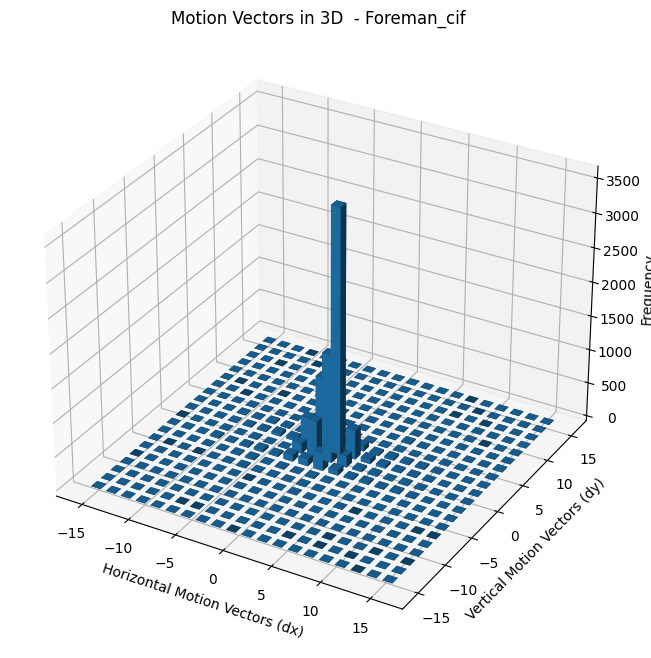

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def read_yuv_frames(filename, width, height, num_frames):
    frames = []  # Initialize an empty list to store frames

    num_bytes_per_frame = width * height * 1.5  # Assuming 4:2:0 chroma subsampling; 1.5 is for combined u and v

    with open(filename, 'rb') as f:
        for _ in range(num_frames):
            # Read data chunk for each frame
            yuv_data = f.read(int(num_bytes_per_frame))

            # Separate Y channel
            y = yuv_data[0: width * height]

            # Reshape channels into NumPy arrays
            y = np.reshape(np.frombuffer(y, dtype=np.uint8), (height, width))

            # Convert Y channel to grayscale
            gray_frame = y
            frames.append(gray_frame)  # Add grayscale frame to the list

    return frames

def motion_estimation(frames, block_size=32, search_area=16):
    num_frames = len(frames)
    motion_vectors = []

    for i in range(num_frames - 1):
        frame1 = frames[i].astype(int)
        frame2 = frames[i + 1].astype(int)

        for y in range(0, frame1.shape[0] - block_size + 1, block_size):
            for x in range(0, frame1.shape[1] - block_size + 1, block_size):
                min_ssd = float('inf')
                best_match = (0, 0)

                # Define current block
                block1 = frame1[y:y + block_size, x:x + block_size]

                # Search in the search area of frame2
                for dy in range(-search_area, search_area + 1):
                    for dx in range(-search_area, search_area + 1):
                        # Define search block in frame2
                        y_start = y + dy
                        y_end = y + dy + block_size
                        x_start = x + dx
                        x_end = x + dx + block_size

                        if (y_start >= 0 and y_end <= frame2.shape[0] and
                            x_start >= 0 and x_end <= frame2.shape[1]):
                            block2 = frame2[y_start:y_end, x_start:x_end]

                            # Calculate SSD
                            ssd = np.sum((block1 - block2) ** 2)
                            if ssd < min_ssd:
                                min_ssd = ssd
                                best_match = (dy, dx)

                # Store motion vector for the current block
                motion_vectors.append(best_match)

    return motion_vectors

filename = '/content/foreman.yuv'
width = 352
height = 288
num_frames = 100

frames = read_yuv_frames(filename, width, height, num_frames)
motion_vectors = motion_estimation(frames)

# Extract motion vector components
dy = np.array([mv[0] for mv in motion_vectors])
dx = np.array([mv[1] for mv in motion_vectors])

# Compute a metric for the z-axis (e.g., magnitude of motion vectors)
magnitudes = np.sqrt(dx**2 + dy**2)

# Creating a 3D surface plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
hist, xedges, yedges = np.histogram2d(dx, dy, bins=20, range=[[-16, 16], [-16, 16]])
xpos, ypos = np.meshgrid(xedges[:-1] + 0.5, yedges[:-1] + 0.5, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)

dx = dy = np.ones_like(zpos)

ax.bar3d(xpos, ypos, zpos, dx, dy, hist.ravel(), zsort='average', cmap='viridis')
ax.set_xlabel('Horizontal Motion Vectors (dx)')
ax.set_ylabel('Vertical Motion Vectors (dy)')
ax.set_zlabel('Frequency')
plt.title('Motion Vectors in 3D  - Foreman_cif')

plt.show()
